# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Import all the modules I need

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib qt



## First, compute the camera calibration using chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
print(images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        cv2.imshow('img',img)
        cv2.waitKey(500)
        

cv2.destroyAllWindows()

['./camera_cal\\calibration1.jpg', './camera_cal\\calibration10.jpg', './camera_cal\\calibration11.jpg', './camera_cal\\calibration12.jpg', './camera_cal\\calibration13.jpg', './camera_cal\\calibration14.jpg', './camera_cal\\calibration15.jpg', './camera_cal\\calibration16.jpg', './camera_cal\\calibration17.jpg', './camera_cal\\calibration18.jpg', './camera_cal\\calibration19.jpg', './camera_cal\\calibration2.jpg', './camera_cal\\calibration20.jpg', './camera_cal\\calibration3.jpg', './camera_cal\\calibration4.jpg', './camera_cal\\calibration5.jpg', './camera_cal\\calibration6.jpg', './camera_cal\\calibration7.jpg', './camera_cal\\calibration8.jpg', './camera_cal\\calibration9.jpg']


In [3]:
# Calculate caribration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# check the test images correctly undistorted

fname =images[1]
img = cv2.imread(fname)
udist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imshow('original',img)
cv2.waitKey(500)
cv2.imshow('undistorted image',udist)
cv2.waitKey(500)
dif1 = np.uint8(img - udist)
dif1 = cv2.cvtColor(dif1, cv2.COLOR_BGR2GRAY)
cv2.imshow('Difference of image',dif1)
cv2.waitKey(500)

cv2.destroyAllWindows()

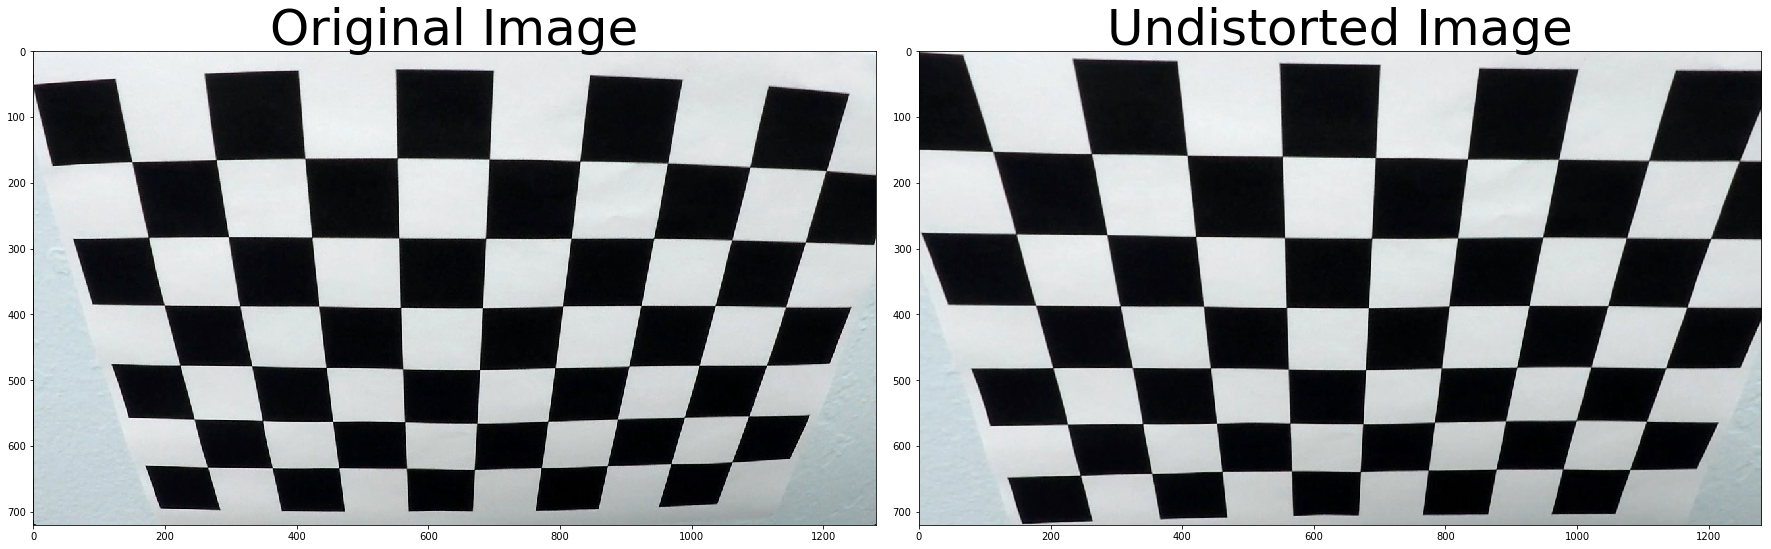

In [4]:
# Plot the result
img = cv2.imread(images[11])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.undistort(img, mtx, dist, None, mtx), cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/UndistortedChessBoard.png')

## Second, undistort test_images

In [5]:
# Read test images
test_images = glob.glob('./test_images/*.jpg')
print(test_images)

# Check test_images
i = 0
img = cv2.imread(test_images[i])
cv2.imshow('img',img)
cv2.waitKey(500)

cv2.destroyAllWindows()

['./test_images\\straight_lines1.jpg', './test_images\\straight_lines2.jpg', './test_images\\test1.jpg', './test_images\\test2.jpg', './test_images\\test3.jpg', './test_images\\test4.jpg', './test_images\\test5.jpg', './test_images\\test6.jpg']


In [6]:
# undistort test images
undists = []

for fname in test_images:
    img = cv2.imread(fname)
    # undistort all images 
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undists.append(undist)
    

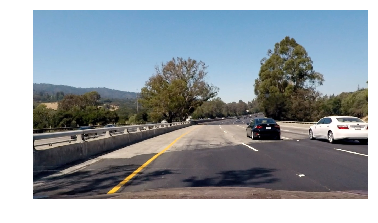

In [7]:
plt.figure()
plt.set_cmap('hot')
plt.axis('off')
plt.imshow(cv2.cvtColor(undists[5], cv2.COLOR_BGR2RGB))
plt.savefig('./output_images/undistorted_test_image.png',bbox_inches='tight')

## Third, threshold images

### define functions that extract the edges of the line

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate vertical or horizontal gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Apply thresholding
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaledmag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a binary mask where mag thresholds are met
    binary = np.zeros_like(scaledmag)
    binary[(scaledmag >= mag_thresh[0]) & (scaledmag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary = np.zeros_like(direction)
    binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary

def s_threshold(image, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_chanel = hls[:,:,2]
    binary_output = np.zeros_like(s_chanel)
    binary_output[(s_chanel >= thresh[0]) & (s_chanel <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary_output

def s_abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate vertical or horizontal gradient of s images
    # Apply threshold
    # Convert to grayscale
    s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(s, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(s, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Apply thresholding
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def s_mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude of s images
    # Apply threshold
    # Convert to grayscale
    s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaledmag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a binary mask where mag thresholds are met
    binary = np.zeros_like(scaledmag)
    binary[(scaledmag >= mag_thresh[0]) & (scaledmag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary

def s_dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction of s images
    # Apply threshold
    # Convert to grayscale
    s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary = np.zeros_like(direction)
    binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary

In [9]:
def extract_edges(undist):
    ksize = 5
    # x direction gray-scale-gradient
    gradx      = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(30, 100)) # i=2 
    # y direction gray-scale-gradient
    grady      = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    # x direction HLS's s space-gradient
    s_gradx      = s_abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    # x direction HLS's s space-gradient
    s_grady      = s_abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(35, 100))
    combined = np.zeros_like(s_gradx)
    combined[((gradx == 1) & (grady == 1))|((s_gradx == 1) & (s_grady == 1))] = 1
    return combined
    

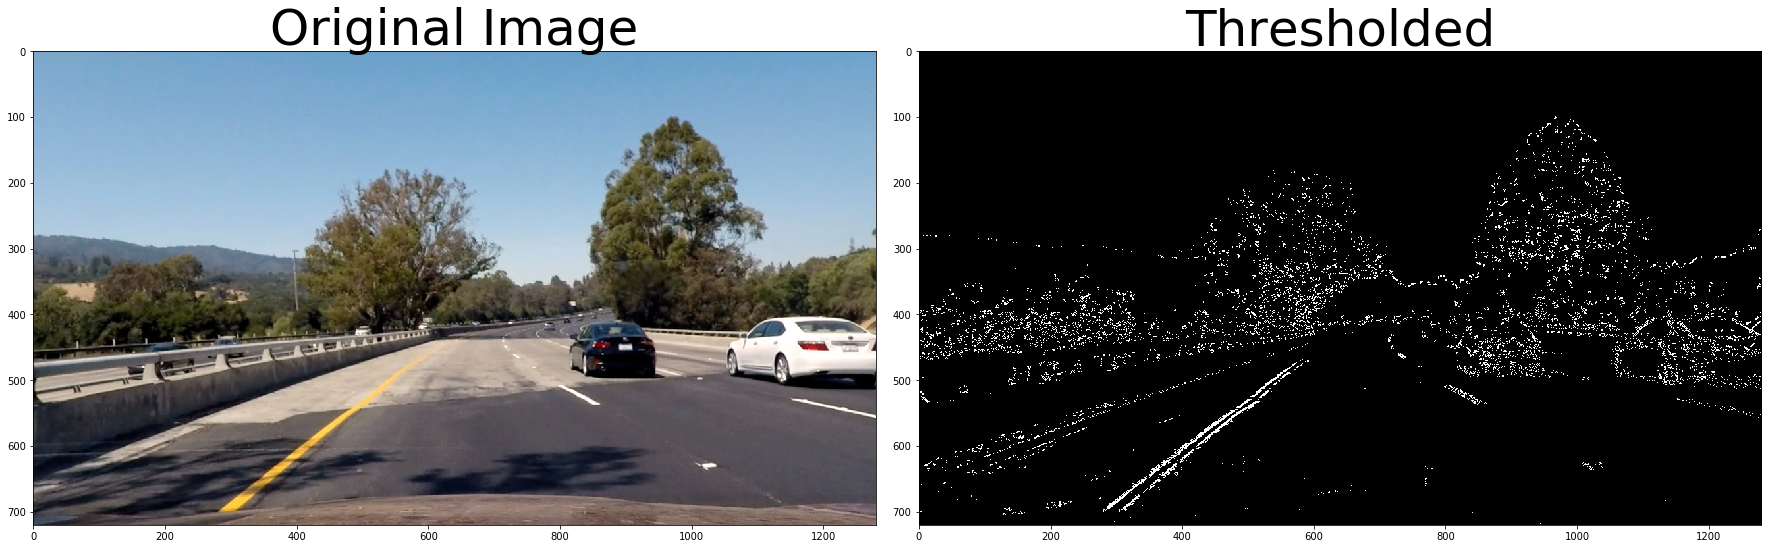

In [10]:
# test edge detection function

image = cv2.cvtColor(undists[5], cv2.COLOR_BGR2RGB)
# Apply each of the thresholding functions
combined = extract_edges(image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/thresholding_image.png',bbox_inches='tight')

## Fourth, apply perspective transform

In [11]:
img_size = undists[0].shape[::-1][1:3]

# define source coordinates and destination coordinates
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 20), img_size[1]],
     [(img_size[0] * 5 / 6) + 20, img_size[1]],
     [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

print(src)
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
print(dst)

M    = cv2.getPerspectiveTransform(src, dst)
invM = cv2.getPerspectiveTransform(dst,src)

[[ 580.       460.     ]
 [ 193.33333  720.     ]
 [1086.6666   720.     ]
 [ 700.       460.     ]]
[[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]


"\n# Plot the thresholded result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(combined, cmap='gray')\nax1.plot(src[(1,0,3,2),0], src[(1,0,3,2),1], 'r')\nax1.set_title('Original thresholded Image', fontsize=50)\nax2.imshow(warped_combined, cmap='gray')\nax2.set_title('Warped thresholded Image', fontsize=50)\nax2.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n\n# Plot the warped s space image and thresholded result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\n#     ax1.imshow(warped)\nax1.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')\nax1.set_title('Warped Image', fontsize=50)\nax1.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')\nax2.imshow(warped_combined, cmap='gray')\nax2.set_title('Warped thresholded Image', fontsize=50)\nax2.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

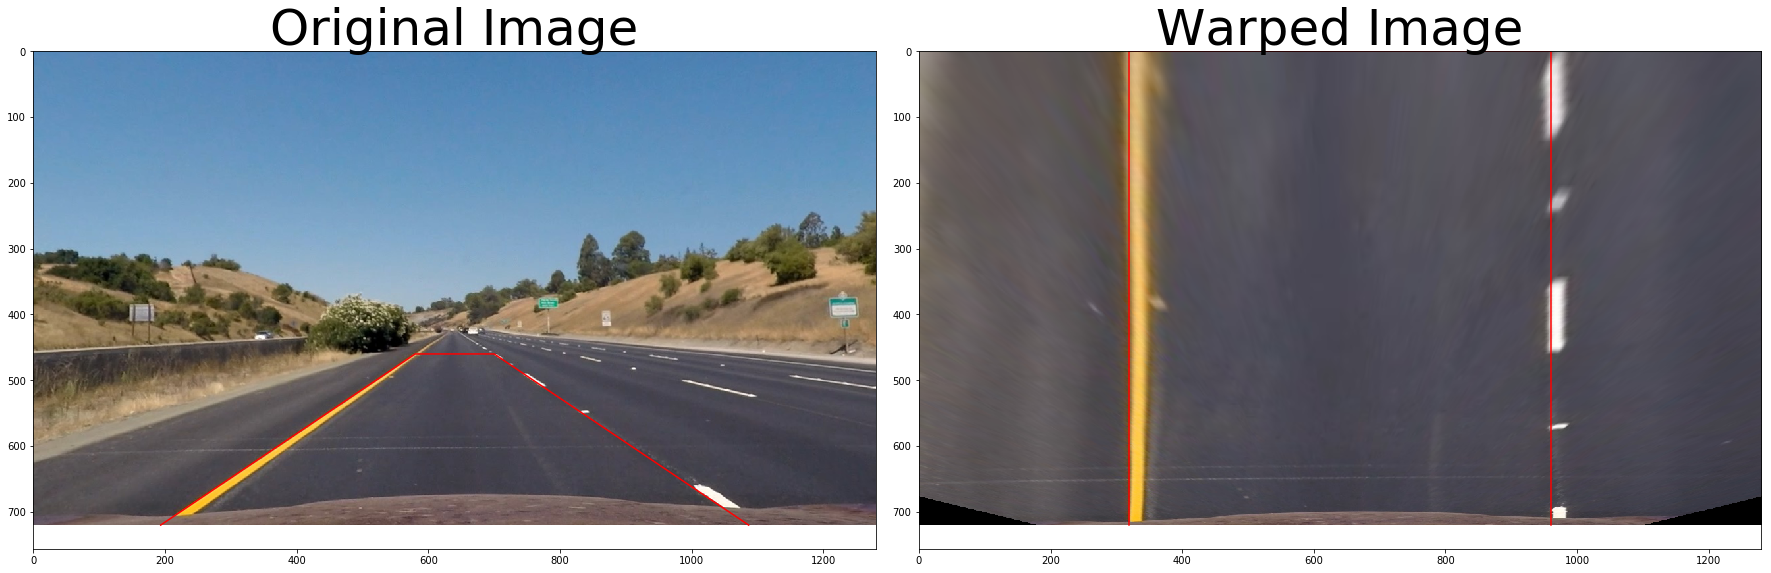

In [13]:
# Check perspective transform perform well
img = cv2.cvtColor(undists[0], cv2.COLOR_BGR2RGB)
combined = extract_edges(img)
warped = cv2.warpPerspective(img, M, img_size)
warped_combined = cv2.warpPerspective(combined, M, img_size)

# Plot the RGB result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.plot(src[(1,0,3,2),0], src[(1,0,3,2),1], 'r')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
ax2.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/warped_straight_line.png',bbox_inches='tight')

'''
# Plot the thresholded result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.plot(src[(1,0,3,2),0], src[(1,0,3,2),1], 'r')
ax1.set_title('Original thresholded Image', fontsize=50)
ax2.imshow(warped_combined, cmap='gray')
ax2.set_title('Warped thresholded Image', fontsize=50)
ax2.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the warped s space image and thresholded result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#     ax1.imshow(warped)
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')
ax1.set_title('Warped Image', fontsize=50)
ax1.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')
ax2.imshow(warped_combined, cmap='gray')
ax2.set_title('Warped thresholded Image', fontsize=50)
ax2.plot(dst[(1,0,3,2),0], dst[(1,0,3,2), 1], 'r')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

## Fifth, fitting the lines

define a class to receive the characteristics of each line detection

In [18]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([False])  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def calcFitx(self, fit, ploty):
        # calculate x values of fitting line
        return fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    def calcCurvature(self, y_value, y_m_per_pix=30/720,x_m_per_pix=3.7/700):
        # Calculate radius of curvature
        new_a = self.best_fit[0] * x_m_per_pix / y_m_per_pix**2
        new_b = self.best_fit[1] * x_m_per_pix / y_m_per_pix
        self.radius_of_curvature = (1.0 + (2.0*new_a*y_value*y_m_per_pix + new_b)**2)**1.5 / np.absolute(2.0* new_a)
    
    def updateBestx(self, ploty, img_size, threshold = 4.0e-4, n=10, minpix=50):
        # do sanity check and update best fitting line
        
        if len(self.ally) < minpix:
            # remove the case that the detected pixel numbers are too small 
            self.detected = False    
        else:
            self.current_fit = np.polyfit(self.ally, self.allx, 2)
            
            if self.best_fit.size != 3:
                # the video's first image
                fit_x =  self.calcFitx(self.current_fit, ploty)
                self.recent_xfitted.append(fit_x)
                self.best_fit = np.polyfit(ploty, fit_x, 2)
                self.bestx = self.calcFitx(self.best_fit, ploty)
                self.calcCurvature(0.0)
                self.detected = True
            elif self.current_fit[0] > self.best_fit[0]-threshold and self.current_fit[0] < self.best_fit[0]+threshold:
                # check the fitting lines curvature does notchanges too rapidly
                if len(self.recent_xfitted)==n:
                    del(self.recent_xfitted[0])
                fit_x =  self.calcFitx(self.current_fit, ploty)
                self.recent_xfitted.append(fit_x)
                # smooth fitting line by averaging
                meanx = np.mean(self.recent_xfitted, axis=0)
                self.best_fit = np.polyfit(ploty, meanx, 2)
                self.bestx = self.calcFitx(self.best_fit, ploty)
                self.calcCurvature(0.0)
                self.detected = True
            else:
                self.detected = False
    
    
    
    def makePosText(self, img_size, left_pos, right_pos, x_m_per_pix=3.7/700):
        # make the text of car's center position
        center = img_size[0]/2
        car_pos = (right_pos + left_pos) /2.0
        off_center = (center - car_pos) * x_m_per_pix
        if off_center < 0.0:
            text = ('Vehicle is %.2f m left of center' % np.absolute(off_center))
        else:
            text = ('Vehicle is %.2f m right of center' % np.absolute(off_center))

        return car_pos, text


fit the positon of lane lines, and calculate radius of curvature  

In [25]:
# the Line classes to keep last line data in video
rightLine  = Line()
leftLine   = Line()
centerLine = Line()
font = cv2.FONT_HERSHEY_SIMPLEX
        
def process_image(img, margin=100, minpix=50, nwindows=9):
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # perspective transform 
    binary_warped = cv2.warpPerspective(extract_edges(undist), M, img_size)
    warped = cv2.warpPerspective(undist, M, img_size)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []
    
    if rightLine.detected:
        # the case that the lane line is detected in last image
        x_values_nonzero = rightLine.calcFitx(rightLine.best_fit, nonzeroy)
        lower_x_limit = x_values_nonzero - margin
        upper_x_limit = x_values_nonzero + margin
        
        right_lane_inds = ((nonzerox > lower_x_limit) & (nonzerox < upper_x_limit))
        

    else:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Current positions to be updated for each window
        rightx_current = rightx_base
        # Step through the windows one by one
        
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            # the points near the camera should be more weighted because they are more precise
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    rightLine.allx = nonzerox[right_lane_inds]
    rightLine.ally = nonzeroy[right_lane_inds] 
    

    
    # Caculate average fit of left line
    rightLine.updateBestx(ploty, img_size)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightLine.bestx, ploty])))])
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    
    if leftLine.detected:
        # the case that the lane line is detected in last image
        x_values_nonzero = leftLine.calcFitx(leftLine.best_fit, nonzeroy)
        lower_x_limit = x_values_nonzero - margin
        upper_x_limit = x_values_nonzero + margin
        left_lane_inds = ((nonzerox > lower_x_limit) & (nonzerox < upper_x_limit))

    else:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        # Current positions to be updated for each window
        leftx_current = leftx_base

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indices to the lists
            # the points near the camera should be more weighted because they are more precise
    #         for i in range((nwindows-window)):
            #TODO:weight the pixel near the car
            left_lane_inds.append(good_left_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
    # Extract left and right line pixel positions
    leftLine.allx = nonzerox[left_lane_inds]
    leftLine.ally = nonzeroy[left_lane_inds] 
    
    
    # Caculate average fit of left line
    leftLine.updateBestx(ploty, img_size)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftLine.bestx, ploty]))])
    
    
    # Calculate centerline position and radius of curvature
    centerLine.bestx = (leftLine.bestx + rightLine.bestx) / 2.0
    centerLine.best_fit = np.polyfit(ploty, centerLine.bestx, 2)
    centerLine.calcCurvature(0.0)
    centerLine.base_pos, pos_message = centerLine.makePosText(img_size, leftLine.bestx[-1], rightLine.bestx[-1])
    
    pts = np.hstack((pts_left, pts_right))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    zero_img = np.zeros_like(warped)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(zero_img, np.int_([pts]), (0,255, 0))
    fit_img = cv2.warpPerspective(zero_img, invM, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, fit_img, 0.3, 0)
    # changes the color of points that are in the windows
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # draw text on the images
    cv2.putText(result, 'Radius of Curvature = ' + str(int(centerLine.radius_of_curvature))+ '(m)', \
               (100,60), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,pos_message , \
               (100,130), font, 2,(255,255,255),2,cv2.LINE_AA)
    # draw fitting line
    cv2.polylines(out_img,  np.int32(pts_left),  False,  (0, 128, 128),  2)
    cv2.polylines(out_img,  np.int32(pts_right),  False,  (0, 128, 128),  2)
#     return out_img
    return result, out_img

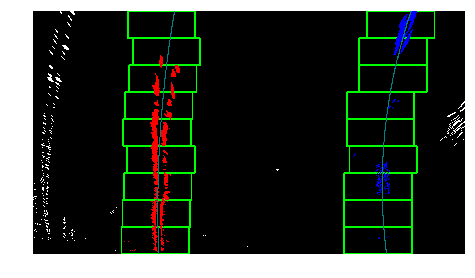

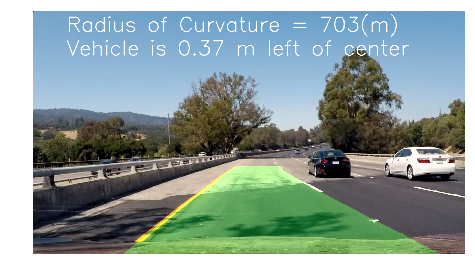

In [16]:
# output example result

img = cv2.imread(test_images[5])
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(result, out_img) = process_image(rgb)

plt.figure()
plt.set_cmap('hot')
plt.axis('off')
plt.imshow(out_img)
plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
plt.savefig('./output_images/fitting_test_image.png',bbox_inches='tight')


plt.figure()
plt.set_cmap('hot')
plt.axis('off')
plt.imshow(result)
plt.subplots_adjust(left=0.0, right=1, top=1.0, bottom=0.0)
plt.savefig('./output_images/lane_tracking_result.png',bbox_inches='tight')

## Sixth, make video

In [26]:
def process_image_video(img):
    return process_image(img)[0]

In [22]:
output = "./output_images/processed_project_video1.mp4"
# clip1 = VideoFileClip('project_video.mp4').subclip(21,27)
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(process_image_video) 
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_project_video1.mp4
[MoviePy] Writing video ./output_images/processed_project_video1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:05<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_project_video1.mp4 

Wall time: 17min 8s


In [28]:
clip1.reader.close()
clip1.audio.reader.close_proc()
clip.reader.close()
clip.audio.reader.close_proc()

In [27]:
output = "./output_images/processed_challenge_video_out.mp4"
# clip1 = VideoFileClip('project_video.mp4').subclip(21,27)
clip1 = VideoFileClip('challenge_video.mp4')
clip = clip1.fl_image(process_image_video) 
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_challenge_video_out.mp4
[MoviePy] Writing video ./output_images/processed_challenge_video_out.mp4


100%|████████████████████████████████████████| 485/485 [01:55<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_challenge_video_out.mp4 

Wall time: 1min 56s


In [29]:
output = "./output_images/processed_harder_challenge_video.mp4"
# clip1 = VideoFileClip('project_video.mp4').subclip(21,27)
clip1 = VideoFileClip('harder_challenge_video.mp4')
clip = clip1.fl_image(process_image_video) 
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_harder_challenge_video.mp4
[MoviePy] Writing video ./output_images/processed_harder_challenge_video.mp4


  9%|███▍                                   | 105/1200 [00:26<04:28,  4.07it/s]

KeyboardInterrupt: 